# Preprocessing

## 1: Import & Load Data
Import library dan load metadata dari CSV.


In [4]:
# Cell 1 — Install dan Import Library
!pip install noisereduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import noisereduce as nr
from IPython.display import Audio
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ Preprocessing libraries imported successfully!")


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Preprocessing libraries imported successfully!


Fungsi Preprocessing 


In [3]:
def preprocess_audio(audio_path, target_sr=22050, duration=2.0):
    """
    Preprocessing lengkap untuk audio buka-tutup
    """
    try:
        # Load audio dengan librosa
        audio, sr = librosa.load(audio_path, sr=target_sr)
        
        # 1. Noise Reduction
        audio_clean = nr.reduce_noise(y=audio, sr=sr, prop_decrease=0.8)
        
        # 2. Normalize audio
        audio_norm = librosa.util.normalize(audio_clean)
        
        # 3. Trim silence
        audio_trim, _ = librosa.effects.trim(audio_norm, top_db=20)
        
        # 4. Fixed length processing
        if len(audio_trim) > int(duration * target_sr):
            # Jika terlalu panjang, ambil bagian tengah
            start = (len(audio_trim) - int(duration * target_sr)) // 2
            audio_fixed = audio_trim[start:start + int(duration * target_sr)]
        else:
            # Jika terlalu pendek, pad dengan silence
            padding = int(duration * target_sr) - len(audio_trim)
            audio_fixed = np.pad(audio_trim, (0, padding), mode='constant')
        
        return audio_fixed, target_sr
    
    except Exception as e:
        print(f"Error preprocessing {audio_path}: {e}")
        return None, None

def augment_audio(audio, sr, augment_type):
    """
    Fungsi augmentasi audio untuk meningkatkan dataset
    """
    try:
        if augment_type == 'time_stretch':
            # Time stretching
            rate = np.random.uniform(0.8, 1.2)
            return librosa.effects.time_stretch(audio, rate=rate)
        
        elif augment_type == 'pitch_shift':
            # Pitch shifting
            n_steps = np.random.randint(-2, 3)
            return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
        
        elif augment_type == 'add_noise':
            # Add Gaussian noise
            noise = np.random.normal(0, 0.005, audio.shape)
            return audio + noise
        
        elif augment_type == 'time_shift':
            # Time shifting
            shift = np.random.randint(int(sr * 0.1))  # Shift max 100ms
            return np.roll(audio, shift)
        
    except Exception as e:
        print(f"Augmentation error: {e}")
        return audio

def create_augmented_dataset(original_audio, sr, num_augmentations=5):
    """
    Buat multiple augmented versions dari satu audio
    """
    augmented_audios = [original_audio]  # Include original
    
    augment_types = ['time_stretch', 'pitch_shift', 'add_noise', 'time_shift']
    
    for i in range(num_augmentations):
        aug_type = np.random.choice(augment_types)
        augmented_audio = augment_audio(original_audio, sr, aug_type)
        augmented_audios.append(augmented_audio)
    
    return augmented_audios

CONTOH SEBELUM DAN SESUDAH PREPROCESSING


🔊 Demo Preprocessing: ardi - buka


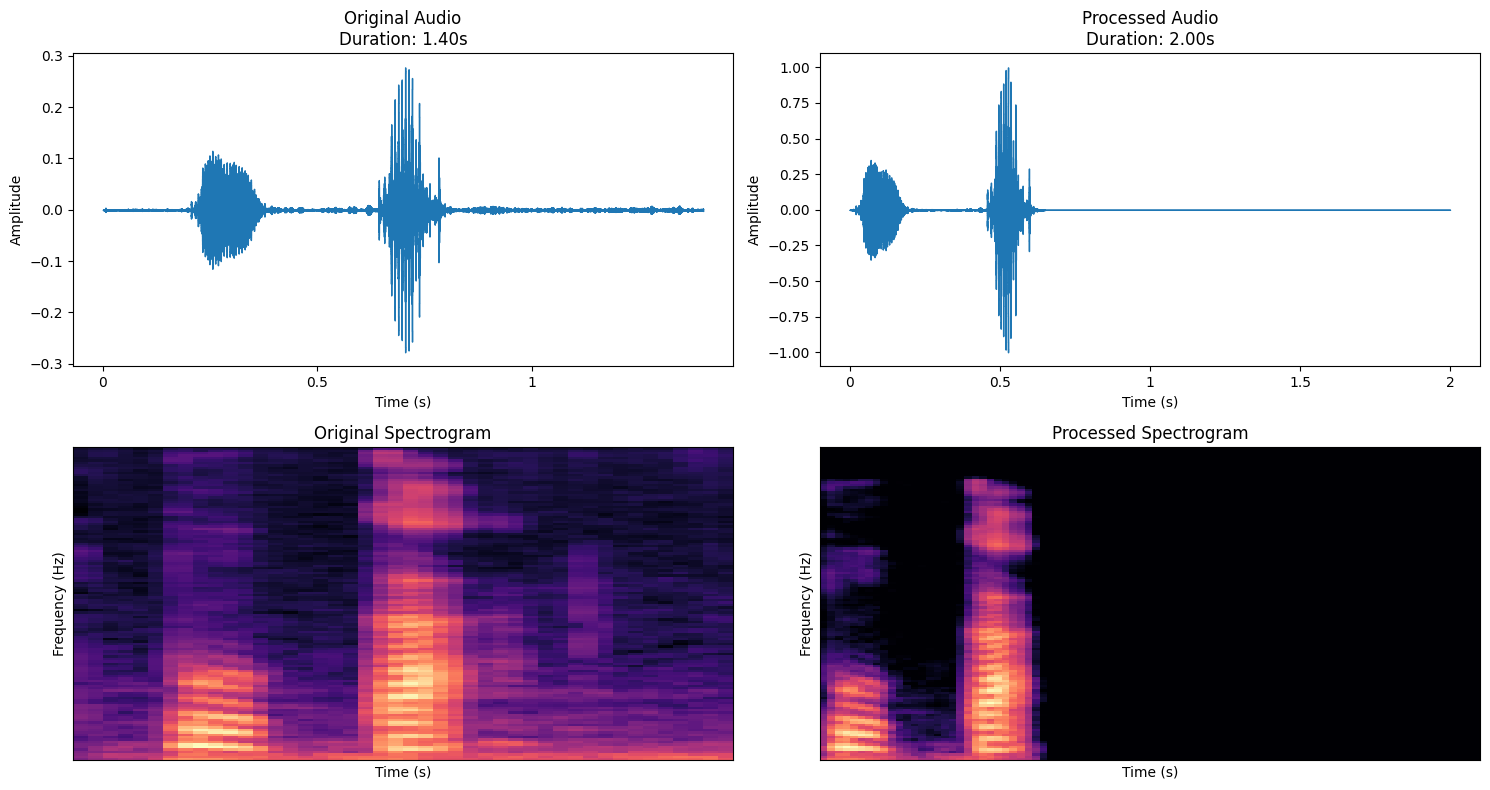

🎧 Original Audio:


🎧 Processed Audio:


In [5]:
# Test preprocessing pada contoh file
def demonstrate_preprocessing():
    # Cari contoh file
    audio_examples = []
    for split in ['train', 'val']:
        split_path = os.path.join("datasetaudio", split)
        if os.path.exists(split_path):
            for person in os.listdir(split_path):
                person_path = os.path.join(split_path, person)
                if os.path.isdir(person_path):
                    for command in ['buka', 'tutup']:
                        command_path = os.path.join(person_path, command)
                        if os.path.exists(command_path):
                            wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
                            if wav_files:
                                audio_examples.append({
                                    'path': os.path.join(command_path, wav_files[0]),
                                    'person': person,
                                    'command': command
                                })
                                break
    
    if audio_examples:
        example = audio_examples[0]
        print(f"🔊 Demo Preprocessing: {example['person']} - {example['command']}")
        
        # Load original
        original_audio, original_sr = librosa.load(example['path'], sr=None)
        
        # Preprocessed
        processed_audio, processed_sr = preprocess_audio(example['path'])
        
        # Plot comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 8))
        
        # Original waveform
        librosa.display.waveshow(original_audio, sr=original_sr, ax=axes[0,0])
        axes[0,0].set_title(f'Original Audio\nDuration: {len(original_audio)/original_sr:.2f}s')
        axes[0,0].set_xlabel('Time (s)')
        axes[0,0].set_ylabel('Amplitude')
        
        # Processed waveform
        librosa.display.waveshow(processed_audio, sr=processed_sr, ax=axes[0,1])
        axes[0,1].set_title(f'Processed Audio\nDuration: {len(processed_audio)/processed_sr:.2f}s')
        axes[0,1].set_xlabel('Time (s)')
        axes[0,1].set_ylabel('Amplitude')
        
        # Original spectrogram
        S_orig = librosa.feature.melspectrogram(y=original_audio, sr=original_sr)
        S_db_orig = librosa.power_to_db(S_orig, ref=np.max)
        librosa.display.specshow(S_db_orig, sr=original_sr, ax=axes[1,0])
        axes[1,0].set_title('Original Spectrogram')
        axes[1,0].set_xlabel('Time (s)')
        axes[1,0].set_ylabel('Frequency (Hz)')
        
        # Processed spectrogram
        S_proc = librosa.feature.melspectrogram(y=processed_audio, sr=processed_sr)
        S_db_proc = librosa.power_to_db(S_proc, ref=np.max)
        librosa.display.specshow(S_db_proc, sr=processed_sr, ax=axes[1,1])
        axes[1,1].set_title('Processed Spectrogram')
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].set_ylabel('Frequency (Hz)')
        
        plt.tight_layout()
        plt.show()
        
        # Audio player comparison
        print("🎧 Original Audio:")
        display(Audio(original_audio, rate=original_sr))
        
        print("🎧 Processed Audio:")
        display(Audio(processed_audio, rate=processed_sr))
        
        return original_audio, original_sr, processed_audio, processed_sr
    else:
        print("❌ No audio files found for demonstration")
        return None, None, None, None

# Jalankan demo
orig_audio, orig_sr, proc_audio, proc_sr = demonstrate_preprocessing()

DATASET HASIL PREPROCESSING

🔄 Processing train/ardi/buka: 50 files
🔄 Processing train/ardi/tutup: 50 files
🔄 Processing train/asep/buka: 50 files
🔄 Processing train/asep/tutup: 50 files
🔄 Processing val/ardi/buka: 20 files
🔄 Processing val/ardi/tutup: 20 files
🔄 Processing val/asep/buka: 20 files
🔄 Processing val/asep/tutup: 20 files

✅ Preprocessing completed!
Total samples: 1480
Training samples: 1400
Validation samples: 80
Augmented samples: 1200


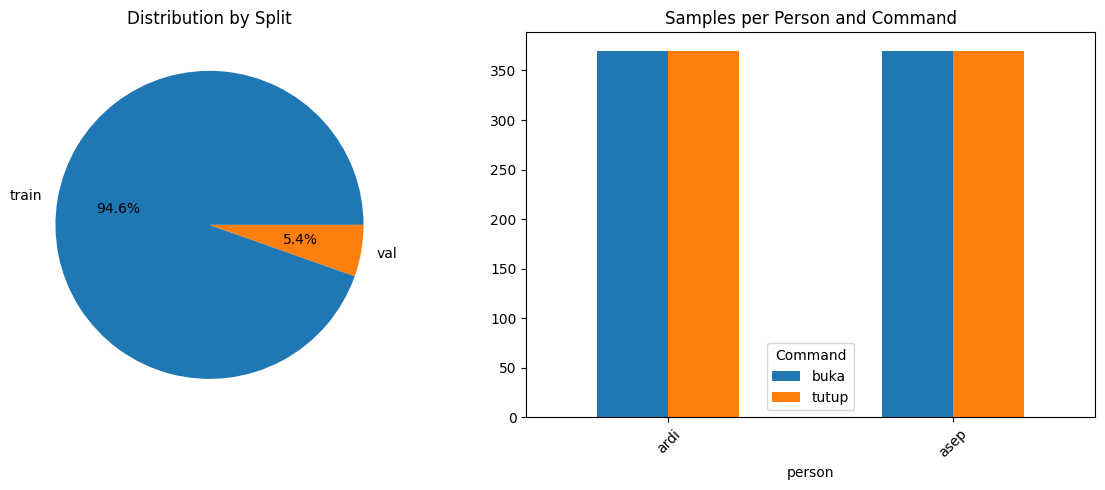

In [6]:
def create_preprocessed_dataset():
    """
    Buat dataset lengkap hasil preprocessing dan augmentasi
    """
    preprocessed_data = []
    target_samples_per_class = 100  # Target 100 sample per kelas
    
    for split in ['train', 'val']:
        split_path = os.path.join("datasetaudio", split)
        if not os.path.exists(split_path):
            continue
            
        for person in os.listdir(split_path):
            person_path = os.path.join(split_path, person)
            if not os.path.isdir(person_path):
                continue
                
            for command in ['buka', 'tutup']:
                command_path = os.path.join(person_path, command)
                if not os.path.exists(command_path):
                    continue
                
                wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
                print(f"🔄 Processing {split}/{person}/{command}: {len(wav_files)} files")
                
                for file in wav_files:
                    file_path = os.path.join(command_path, file)
                    
                    # Preprocess audio
                    processed_audio, sr = preprocess_audio(file_path)
                    
                    if processed_audio is not None:
                        # Simpan data original
                        preprocessed_data.append({
                            'split': split,
                            'person': person,
                            'command': command,
                            'file': file,
                            'audio': processed_audio,
                            'sr': sr,
                            'is_augmented': False
                        })
                        
                        # Augmentasi untuk data training
                        if split == 'train':
                            augmented_audios = create_augmented_dataset(processed_audio, sr, num_augmentations=6)
                            
                            for i, aug_audio in enumerate(augmented_audios[1:]):  # Skip original
                                preprocessed_data.append({
                                    'split': split,
                                    'person': person,
                                    'command': command,
                                    'file': f"{file}_aug_{i}",
                                    'audio': aug_audio,
                                    'sr': sr,
                                    'is_augmented': True
                                })
    
    # Convert to DataFrame
    df_preprocessed = pd.DataFrame(preprocessed_data)
    
    print(f"\n✅ Preprocessing completed!")
    print(f"Total samples: {len(df_preprocessed)}")
    print(f"Training samples: {len(df_preprocessed[df_preprocessed['split'] == 'train'])}")
    print(f"Validation samples: {len(df_preprocessed[df_preprocessed['split'] == 'val'])}")
    print(f"Augmented samples: {len(df_preprocessed[df_preprocessed['is_augmented'] == True])}")
    
    return df_preprocessed

# Buat dataset preprocessing
df_preprocessed = create_preprocessed_dataset()

# Tampilkan distribusi
if not df_preprocessed.empty:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    split_counts = df_preprocessed['split'].value_counts()
    plt.pie(split_counts.values, labels=split_counts.index, autopct='%1.1f%%')
    plt.title('Distribution by Split')
    
    plt.subplot(1, 2, 2)
    command_counts = df_preprocessed.groupby(['person', 'command']).size().unstack()
    command_counts.plot(kind='bar', ax=plt.gca())
    plt.title('Samples per Person and Command')
    plt.xticks(rotation=45)
    plt.legend(title='Command')
    plt.tight_layout()
    
    plt.show()


## 2: FEATURE EXTRACTION (STATISTIK TIME SERIES)


In [7]:
print("🎯 Starting Feature Extraction...")

# Pastikan kita punya data preprocessing
if 'df_preprocessed' not in locals() or df_preprocessed.empty:
    print("❌ No preprocessed data found. Please run preprocessing first.")
else:
    print(f"📊 Loaded {len(df_preprocessed)} preprocessed samples")

🎯 Starting Feature Extraction...
📊 Loaded 1480 preprocessed samples


In [8]:
def extract_time_series_features(audio, sr):
    """
    Ekstrak fitur statistik time series dari sinyal audio
    """
    features = {}
    
    # 1. Basic Time Domain Features
    features['rms_energy'] = np.sqrt(np.mean(audio**2))
    features['zcr'] = librosa.feature.zero_crossing_rate(audio)[0, 0]
    features['energy_entropy'] = np.sum(-audio**2 * np.log(audio**2 + 1e-10))
    
    # 2. Statistical Features
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['skewness'] = pd.Series(audio).skew()
    features['kurtosis'] = pd.Series(audio).kurtosis()
    features['max_amp'] = np.max(np.abs(audio))
    features['min_amp'] = np.min(audio)
    features['range_amp'] = features['max_amp'] - features['min_amp']
    
    # 3. Spectral Features
    stft = np.abs(librosa.stft(audio))
    
    # Spectral centroid dan spread
    spectral_centroid = librosa.feature.spectral_centroid(S=stft, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_std'] = np.std(spectral_centroid)
    
    # Spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(S=stft, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    # Spectral flux
    spectral_flux = np.sum(np.diff(stft, axis=1)**2, axis=0)
    features['spectral_flux_mean'] = np.mean(spectral_flux)
    features['spectral_flux_std'] = np.std(spectral_flux)
    
    # 4. MFCC Statistics (13 MFCCs + statistics)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
        features[f'mfcc_{i+1}_min'] = np.min(mfccs[i])
        features[f'mfcc_{i+1}_max'] = np.max(mfccs[i])
    
    # 5. Chroma Features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    for i in range(12):
        features[f'chroma_{i+1}'] = chroma_mean[i]
    
    # 6. Temporal Features - Energy envelope
    frame_length = 1024
    hop_length = 512
    rms = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    features['rms_skew'] = pd.Series(rms).skew()
    
    # 7. Additional Statistical Moments
    features['percentile_25'] = np.percentile(audio, 25)
    features['percentile_50'] = np.percentile(audio, 50)
    features['percentile_75'] = np.percentile(audio, 75)
    features['iqr'] = features['percentile_75'] - features['percentile_25']
    
    return features

def extract_features_batch(df):
    """
    Ekstrak fitur untuk semua data dalam batch
    """
    features_list = []
    
    for idx, row in df.iterrows():
        try:
            features = extract_time_series_features(row['audio'], row['sr'])
            features['split'] = row['split']
            features['person'] = row['person']
            features['command'] = row['command']
            features['file'] = row['file']
            features['is_augmented'] = row['is_augmented']
            
            features_list.append(features)
            
        except Exception as e:
            print(f"Error extracting features for {row['file']}: {e}")
    
    return pd.DataFrame(features_list)

In [9]:
print("🔄 Extracting features from preprocessed data...")

# Ekstrak fitur untuk semua data
df_features = extract_features_batch(df_preprocessed)

print(f"✅ Feature extraction completed!")
print(f"Total samples with features: {len(df_features)}")
print(f"Feature dimensions: {df_features.shape[1] - 5} audio features")  # minus metadata columns

# Tampilkan preview
print("\n📋 Features preview:")
print(df_features.iloc[:, :10].head())  # Tampilkan 10 kolom pertama

# Simpan dataset fitur
df_features.to_csv('audio_features_dataset.csv', index=False)
print("💾 Features saved to 'audio_features_dataset.csv'")

🔄 Extracting features from preprocessed data...
✅ Feature extraction completed!
Total samples with features: 1480
Feature dimensions: 87 audio features

📋 Features preview:
   rms_energy       zcr  energy_entropy      mean       std  skewness  \
0    0.062971  0.010254      404.649719 -0.001345  0.062957  2.047003   
1    0.062971  0.000000      404.649719 -0.001345  0.062957  2.047003   
2    0.053408  0.012207      396.066345 -0.000875  0.053401  0.036316   
3    0.063165  0.124023      414.274684 -0.001305  0.063152  2.019293   
4    0.063149  0.112305      414.031540 -0.001333  0.063134  2.024790   

    kurtosis   max_amp   min_amp  range_amp  
0  52.421318  1.000000 -0.745748   1.745748  
1  52.421318  1.000000 -0.745748   1.745748  
2  21.386480  0.514630 -0.470685   0.985315  
3  51.650075  1.000110 -0.742214   1.742323  
4  51.839216  0.997682 -0.744811   1.742493  
💾 Features saved to 'audio_features_dataset.csv'


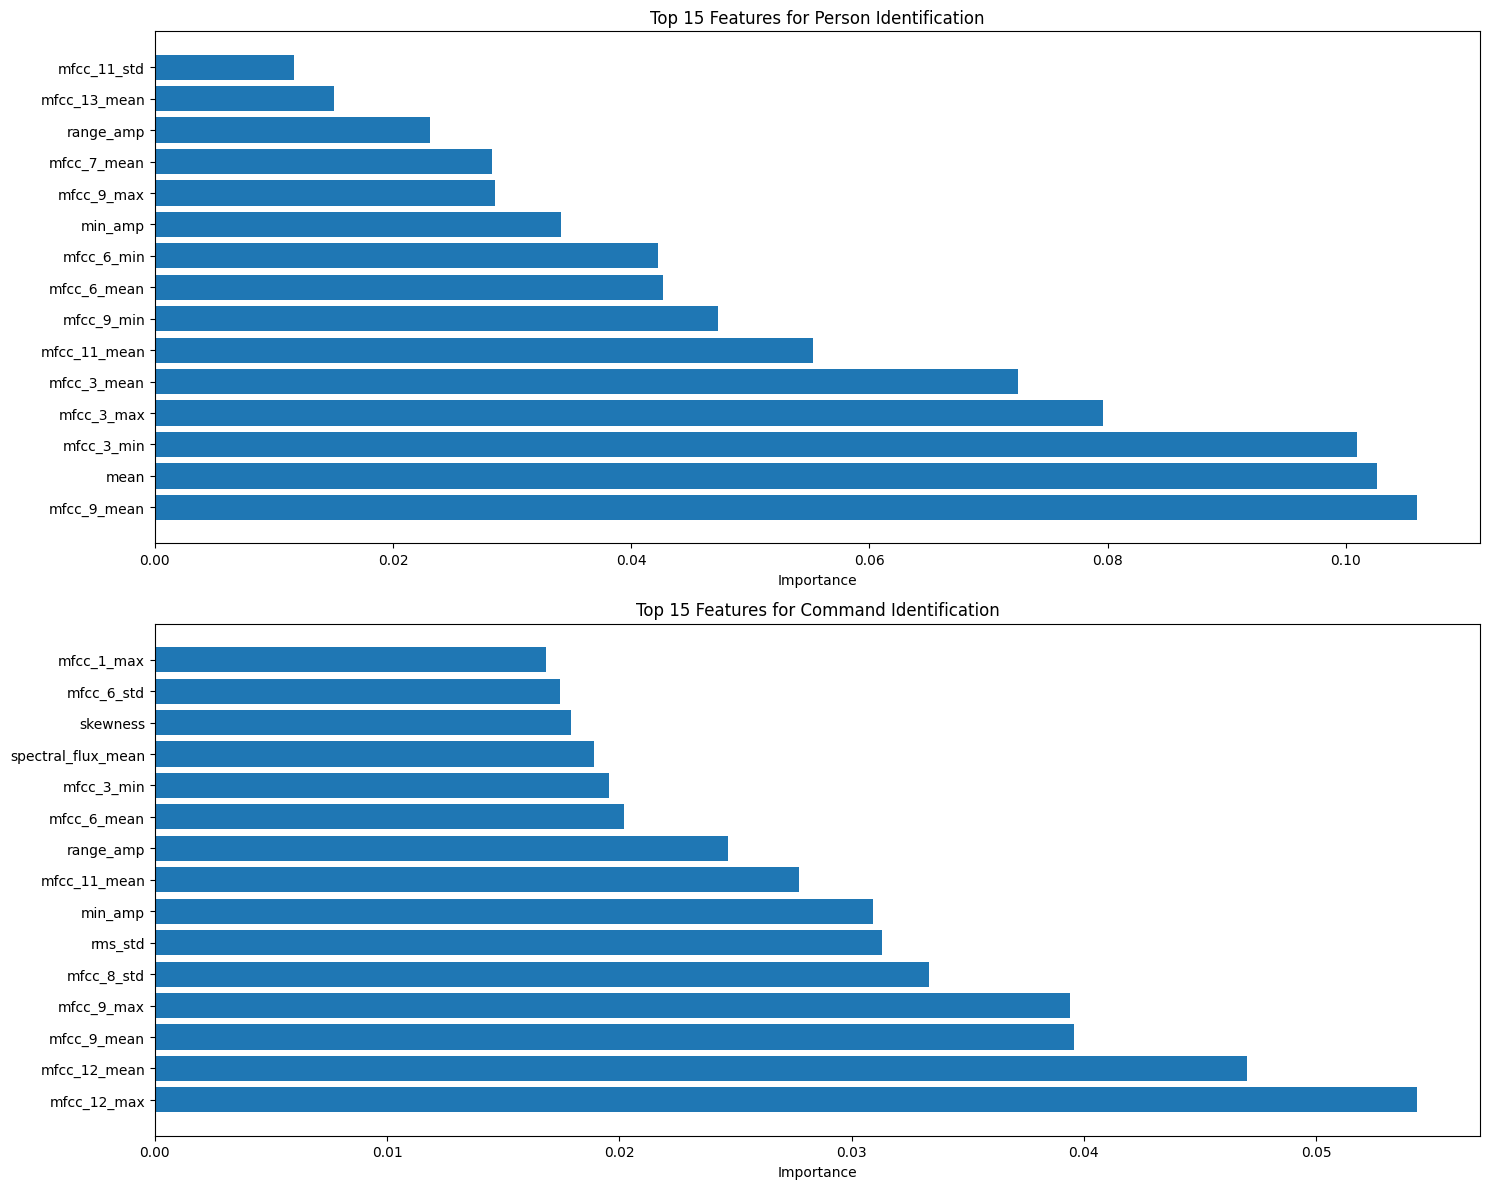

🎯 Feature Importance Analysis Completed!
Total features available: 87


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Prepare data untuk feature importance analysis
feature_columns = [col for col in df_features.columns if col not in 
                  ['split', 'person', 'command', 'file', 'is_augmented']]

X = df_features[feature_columns]
y_person = df_features['person']  # Target: identifikasi orang
y_command = df_features['command']  # Target: identifikasi command

# Encode labels
le_person = LabelEncoder()
le_command = LabelEncoder()

y_person_encoded = le_person.fit_transform(y_person)
y_command_encoded = le_command.fit_transform(y_command)

# Feature Importance untuk Person Identification
rf_person = RandomForestClassifier(n_estimators=100, random_state=42)
rf_person.fit(X, y_person_encoded)

# Feature Importance untuk Command Identification  
rf_command = RandomForestClassifier(n_estimators=100, random_state=42)
rf_command.fit(X, y_command_encoded)

# Plot Feature Importance
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Person importance
person_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_person.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(person_importance['feature'], person_importance['importance'])
axes[0].set_title('Top 15 Features for Person Identification')
axes[0].set_xlabel('Importance')

# Command importance
command_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_command.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(command_importance['feature'], command_importance['importance'])
axes[1].set_title('Top 15 Features for Command Identification')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

print("🎯 Feature Importance Analysis Completed!")
print(f"Total features available: {len(feature_columns)}")

📊 Detailed Feature Analysis
Top features for person ID: ['mfcc_9_mean', 'mean', 'mfcc_3_min', 'mfcc_3_max', 'mfcc_3_mean']...
Top features for command ID: ['mfcc_12_max', 'mfcc_12_mean', 'mfcc_9_mean', 'mfcc_9_max', 'mfcc_8_std']...


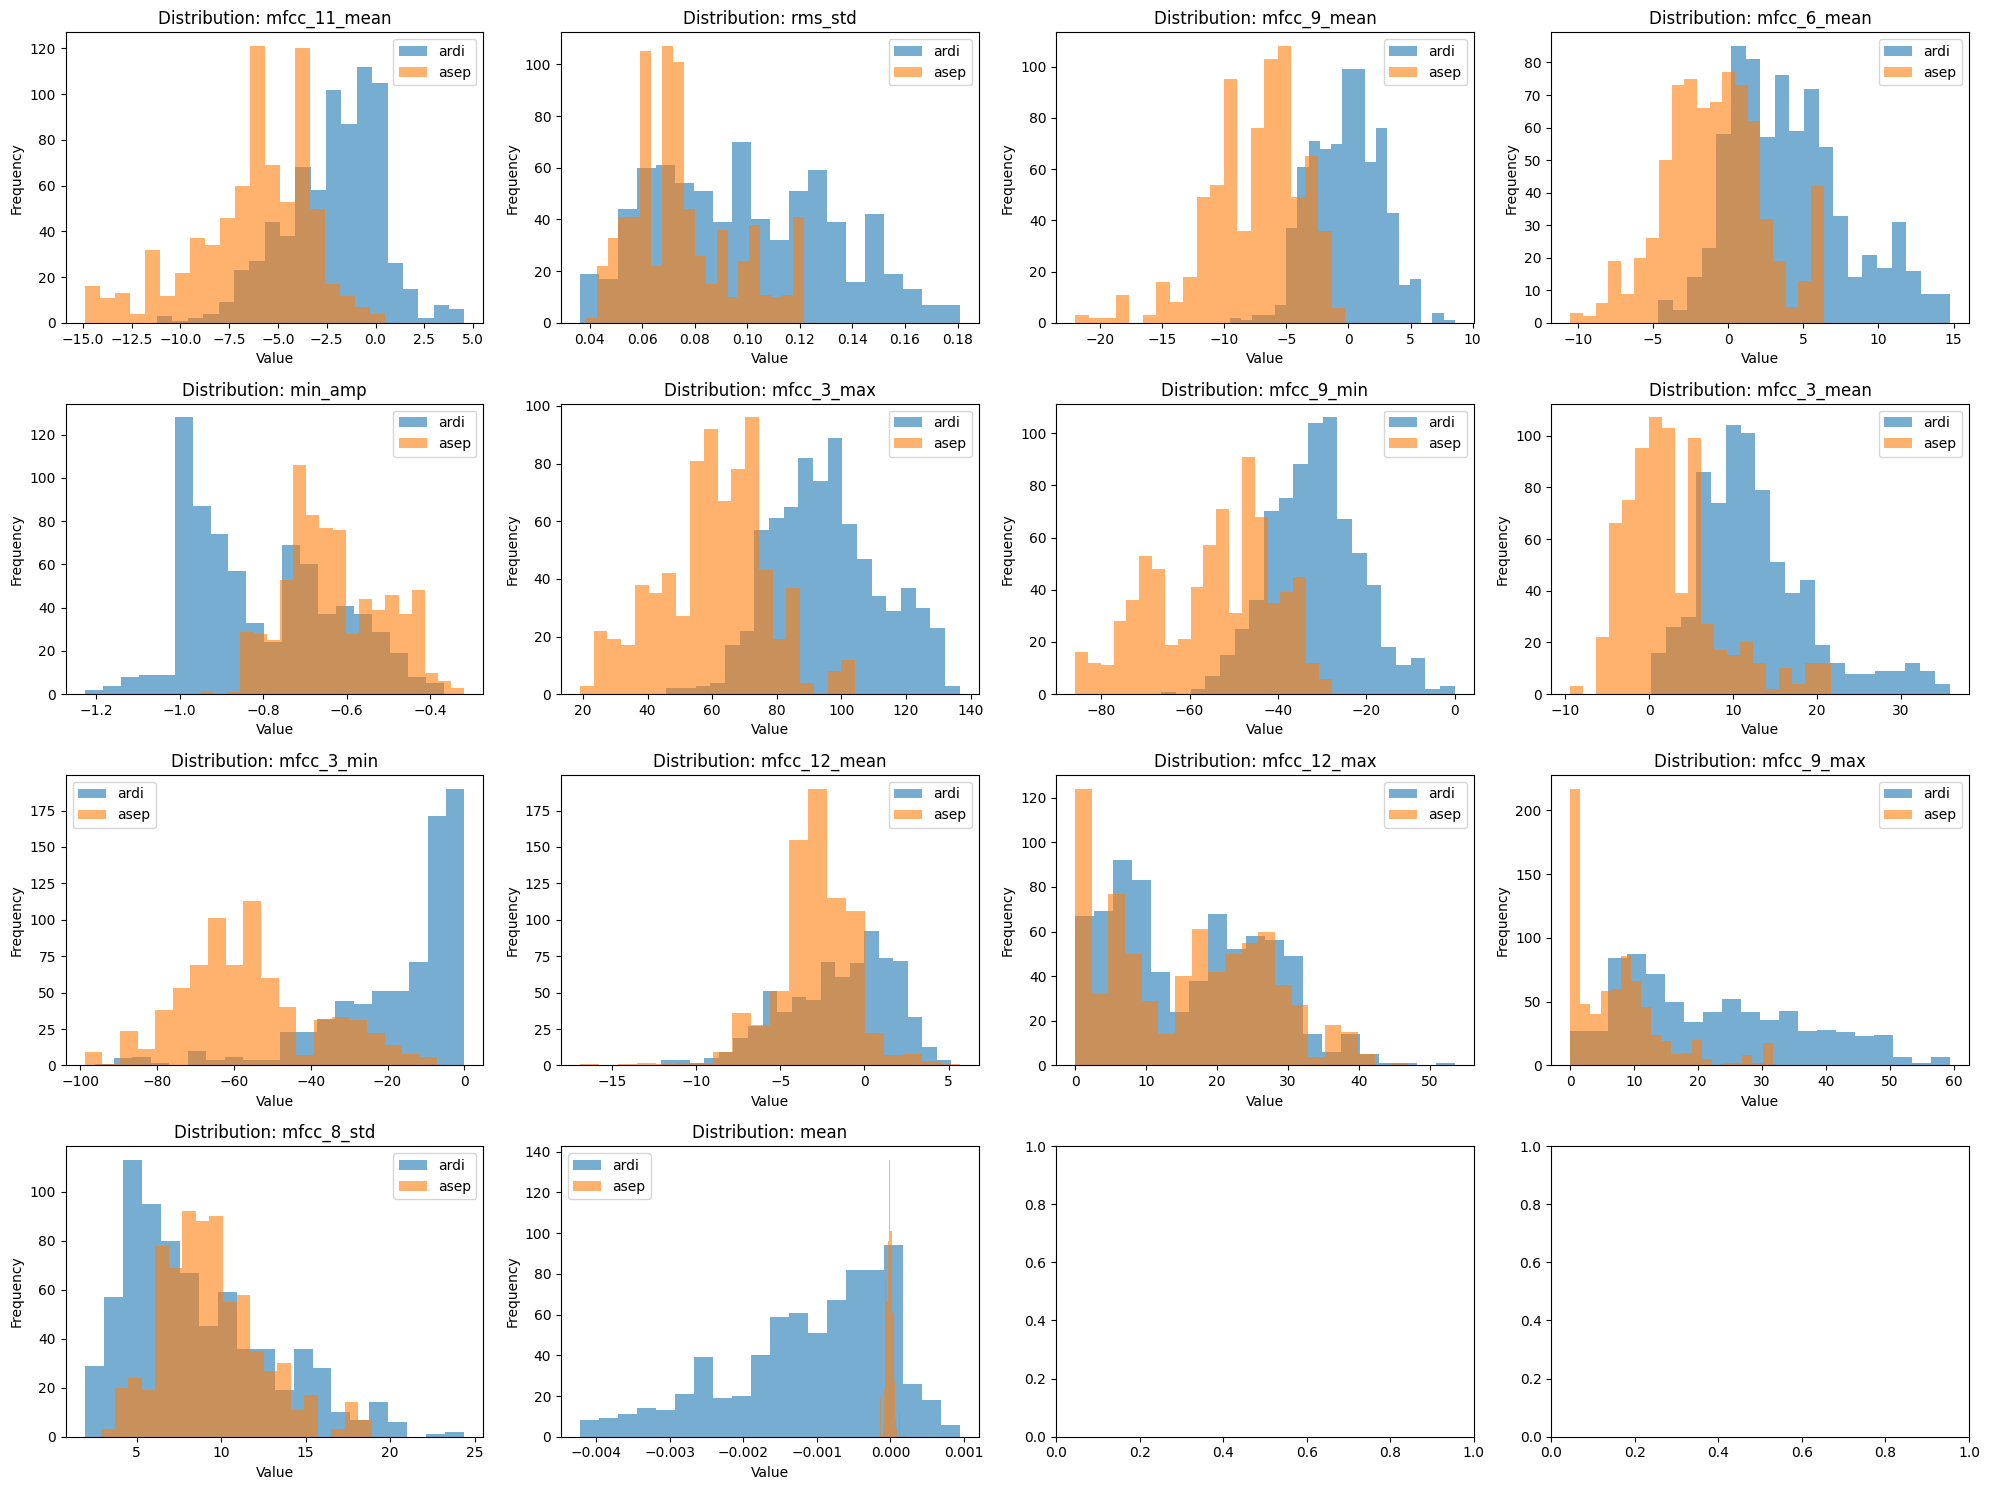

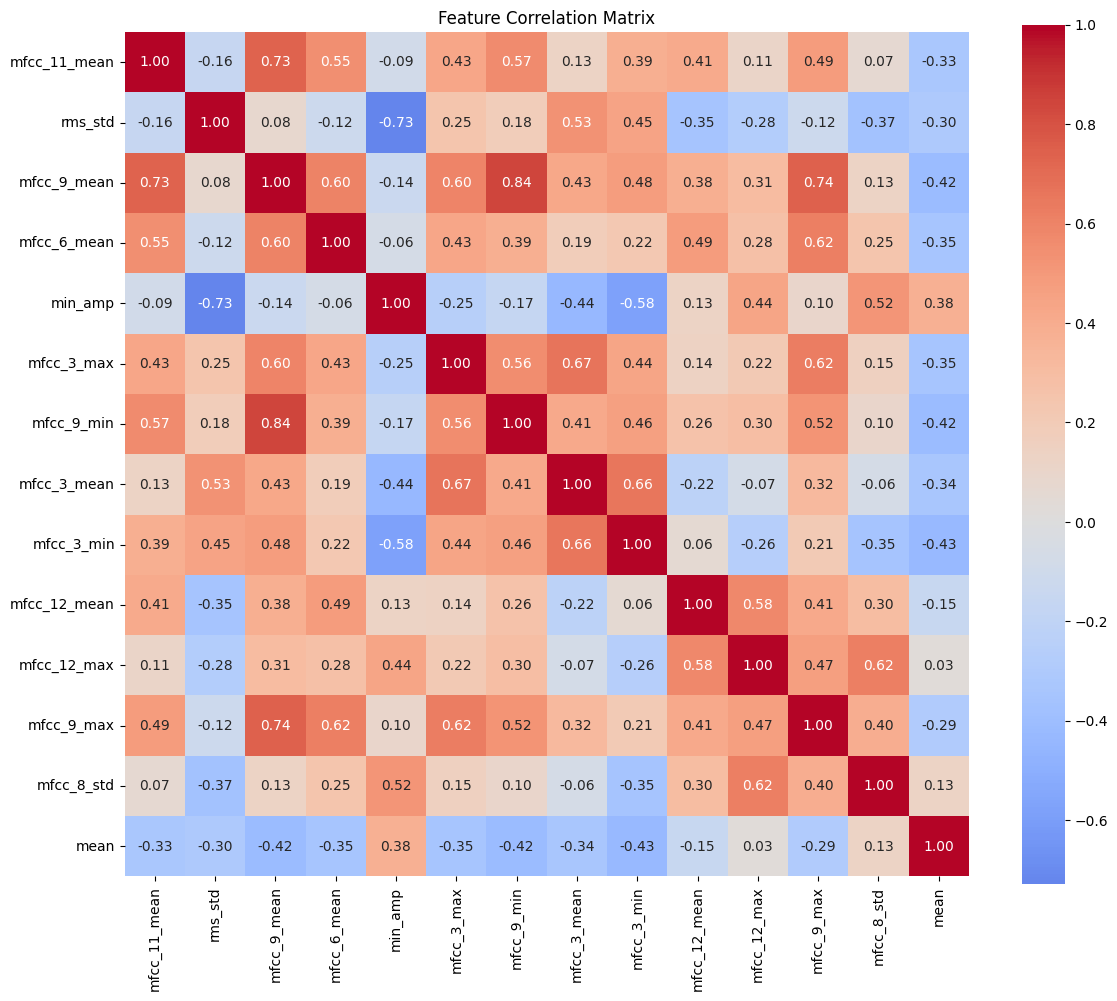

In [11]:
# Analisis korelasi dan distribusi fitur
print("📊 Detailed Feature Analysis")

# Pilih fitur-fitur terpenting
top_person_features = person_importance['feature'].head(10).tolist()
top_command_features = command_importance['feature'].head(10).tolist()

print(f"Top features for person ID: {top_person_features[:5]}...")
print(f"Top features for command ID: {top_command_features[:5]}...")

# Analisis distribusi fitur terpilih
selected_features = list(set(top_person_features[:8] + top_command_features[:8]))

fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(selected_features[:16]):
    if feature in df_features.columns:
        # Plot distribusi per orang
        for person in df_features['person'].unique():
            person_data = df_features[df_features['person'] == person][feature]
            axes[i].hist(person_data, alpha=0.6, label=person, bins=20)
        
        axes[i].set_title(f'Distribution: {feature}')
        axes[i].legend()
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Correlation analysis
correlation_matrix = df_features[selected_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [12]:
from sklearn.ensemble import IsolationForest
from scipy import stats

print("🔍 Outlier Detection and Handling")

def detect_and_handle_outliers(df, features):
    """
    Deteksi dan handle outliers dalam dataset fitur
    """
    df_clean = df.copy()
    
    outlier_info = {}
    
    for feature in features:
        if feature in df.columns:
            # Method 1: Z-score
            z_scores = np.abs(stats.zscore(df[feature]))
            outliers_z = np.where(z_scores > 3)[0]
            
            # Method 2: IQR
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            outliers_iqr = df[(df[feature] < (Q1 - 1.5 * IQR)) | 
                             (df[feature] > (Q3 + 1.5 * IQR))].index
            
            outlier_info[feature] = {
                'z_score_outliers': len(outliers_z),
                'iqr_outliers': len(outliers_iqr),
                'total_samples': len(df)
            }
            
            # Cap outliers menggunakan IQR method
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            df_clean[feature] = np.where(df_clean[feature] < lower_bound, lower_bound, df_clean[feature])
            df_clean[feature] = np.where(df_clean[feature] > upper_bound, upper_bound, df_clean[feature])
    
    # Print outlier summary
    outlier_summary = pd.DataFrame(outlier_info).T
    outlier_summary['z_score_percentage'] = (outlier_summary['z_score_outliers'] / outlier_summary['total_samples']) * 100
    outlier_summary['iqr_percentage'] = (outlier_summary['iqr_outliers'] / outlier_summary['total_samples']) * 100
    
    print("📈 Outlier Summary:")
    print(outlier_summary)
    
    return df_clean

# Handle outliers untuk fitur terpilih
df_features_clean = detect_and_handle_outliers(df_features, selected_features)

print(f"✅ Outlier handling completed!")
print(f"Original dataset shape: {df_features.shape}")
print(f"Cleaned dataset shape: {df_features_clean.shape}")

# Simpan dataset final
df_features_clean.to_csv('audio_features_clean.csv', index=False)
print("💾 Cleaned features saved to 'audio_features_clean.csv'")

🔍 Outlier Detection and Handling
📈 Outlier Summary:
              z_score_outliers  iqr_outliers  total_samples  \
mfcc_11_mean                 4            27           1480   
rms_std                      6            12           1480   
mfcc_9_mean                  7            18           1480   
mfcc_6_mean                  0            16           1480   
min_amp                      0             0           1480   
mfcc_3_max                   0             0           1480   
mfcc_9_min                   0             1           1480   
mfcc_3_mean                 16            34           1480   
mfcc_3_min                   0             0           1480   
mfcc_12_mean                 9            19           1480   
mfcc_12_max                  1             1           1480   
mfcc_9_max                   8            32           1480   
mfcc_8_std                   4            38           1480   
mean                        34           134           1480   

  